<a href="https://colab.research.google.com/github/RajaniBoddupally/0901_Project_CarPricePrediction/blob/main/0901_Project_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
Cardetails_File = '/content/drive/My Drive/Car_Details.csv'
Car_Details_Data = pd.read_csv(Cardetails_File)
print(Car_Details_Data.head())

                           name  year  selling_price  km_driven    fuel  \
0        Maruti Swift Dzire VDI  2014         450000     145500  Diesel   
1  Skoda Rapid 1.5 TDI Ambition  2014         370000     120000  Diesel   
2      Honda City 2017-2020 EXi  2006         158000     140000  Petrol   
3     Hyundai i20 Sportz Diesel  2010         225000     127000  Diesel   
4        Maruti Swift VXI BSIII  2007         130000     120000  Petrol   

  seller_type transmission         owner     mileage   engine   max_power  \
0  Individual       Manual   First Owner   23.4 kmpl  1248 CC      74 bhp   
1  Individual       Manual  Second Owner  21.14 kmpl  1498 CC  103.52 bhp   
2  Individual       Manual   Third Owner   17.7 kmpl  1497 CC      78 bhp   
3  Individual       Manual   First Owner   23.0 kmpl  1396 CC      90 bhp   
4  Individual       Manual   First Owner   16.1 kmpl  1298 CC    88.2 bhp   

                     torque  seats  
0            190Nm@ 2000rpm    5.0  
1       250N

In [7]:
print(f'Shape of the Dataset before pre-processing:{Car_Details_Data.shape}')

Shape of the Dataset before pre-processing:(8128, 13)


In [8]:
Car_Details_Data.isna().sum()

,0
name,0
year,0
selling_price,0
km_driven,0
fuel,0
seller_type,0
transmission,0
owner,0
mileage,221
engine,221


In [9]:
Car_Details_Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           8128 non-null   object 
 1   year           8128 non-null   int64  
 2   selling_price  8128 non-null   int64  
 3   km_driven      8128 non-null   int64  
 4   fuel           8128 non-null   object 
 5   seller_type    8128 non-null   object 
 6   transmission   8128 non-null   object 
 7   owner          8128 non-null   object 
 8   mileage        7907 non-null   object 
 9   engine         7907 non-null   object 
 10  max_power      7913 non-null   object 
 11  torque         7906 non-null   object 
 12  seats          7907 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 825.6+ KB


In [13]:
import pandas as pd
import re


def extract_numeric(value):
    if isinstance(value, str):
        numeric_value = re.findall(r"[-+]?\d*\.\d+|\d+", value)
        return numeric_value[0] if numeric_value else None
    return value

Car_Details_Data['mileage'] = Car_Details_Data['mileage'].apply(extract_numeric)
Car_Details_Data['engine'] = Car_Details_Data['engine'].apply(extract_numeric)
Car_Details_Data['max_power'] = Car_Details_Data['max_power'].apply(extract_numeric)
Car_Details_Data['torque'] = Car_Details_Data['torque'].apply(lambda x: re.findall(r"[-+]?\d*\.\d+|\d+", x)[0] if isinstance(x, str) and re.findall(r"[-+]?\d*\.\d+|\d+", x) else None)

Car_Details_Data[['mileage', 'engine', 'max_power', 'torque']] = Car_Details_Data[['mileage', 'engine', 'max_power', 'torque']].astype(float, errors='ignore')

print(Car_Details_Data)


                              name  year  selling_price  km_driven    fuel  \
0           Maruti Swift Dzire VDI  2014         450000     145500  Diesel   
1     Skoda Rapid 1.5 TDI Ambition  2014         370000     120000  Diesel   
2         Honda City 2017-2020 EXi  2006         158000     140000  Petrol   
3        Hyundai i20 Sportz Diesel  2010         225000     127000  Diesel   
4           Maruti Swift VXI BSIII  2007         130000     120000  Petrol   
...                            ...   ...            ...        ...     ...   
8123             Hyundai i20 Magna  2013         320000     110000  Petrol   
8124         Hyundai Verna CRDi SX  2007         135000     119000  Diesel   
8125        Maruti Swift Dzire ZDi  2009         382000     120000  Diesel   
8126               Tata Indigo CR4  2013         290000      25000  Diesel   
8127               Tata Indigo CR4  2013         290000      25000  Diesel   

     seller_type transmission                 owner  mileage  e

In [14]:
from sklearn.impute import KNNImputer

missval_impute_KNN = KNNImputer(n_neighbors=5)
Car_Details_Data[['mileage', 'engine', 'max_power', 'torque', 'seats']] = missval_impute_KNN.fit_transform(Car_Details_Data[['mileage', 'engine', 'max_power', 'torque', 'seats']])


In [15]:
Car_Details_Data.isna().sum()

,0
name,0
year,0
selling_price,0
km_driven,0
fuel,0
seller_type,0
transmission,0
owner,0
mileage,0
engine,0


In [16]:
# Check for duplicates
Duplicate_Check = Car_Details_Data.duplicated()

# Display the number of duplicate rows
Cnt_Car_Duplicates = Duplicate_Check.sum()
print(f'Number of duplicate rows: {Cnt_Car_Duplicates}')

Number of duplicate rows: 1202


In [18]:
# Remove duplicate rows
CarData_Post_Prepro = Car_Details_Data.drop_duplicates()

# Confirm the removal by checking the number of duplicates again
Cnt_Dup_Removal = CarData_Post_Prepro.duplicated().sum()
print(f'Number of duplicate rows after removal: {Cnt_Dup_Removal}')


Number of duplicate rows after removal: 0


In [19]:
print(f'Shape of the Dataset after duplicates removal:{CarData_Post_Prepro.shape}')

Shape of the Dataset after duplicates removal:(6926, 13)


In [23]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
CarData_Post_Prepro['fuel'] = le.fit_transform(CarData_Post_Prepro['fuel'])
CarData_Post_Prepro['seller_type'] = le.fit_transform(CarData_Post_Prepro['seller_type'])
CarData_Post_Prepro['transmission'] = le.fit_transform(CarData_Post_Prepro['transmission'])
CarData_Post_Prepro['owner'] = le.fit_transform(CarData_Post_Prepro['owner'])


In [24]:
CarData_Post_Prepro.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6926 entries, 0 to 8125
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           6926 non-null   object 
 1   year           6926 non-null   int64  
 2   selling_price  6926 non-null   int64  
 3   km_driven      6926 non-null   int64  
 4   fuel           6926 non-null   int64  
 5   seller_type    6926 non-null   int64  
 6   transmission   6926 non-null   int64  
 7   owner          6926 non-null   int64  
 8   mileage        6926 non-null   float64
 9   engine         6926 non-null   float64
 10  max_power      6926 non-null   float64
 11  torque         6926 non-null   float64
 12  seats          6926 non-null   float64
dtypes: float64(5), int64(7), object(1)
memory usage: 757.5+ KB


<Axes: xlabel='selling_price'>

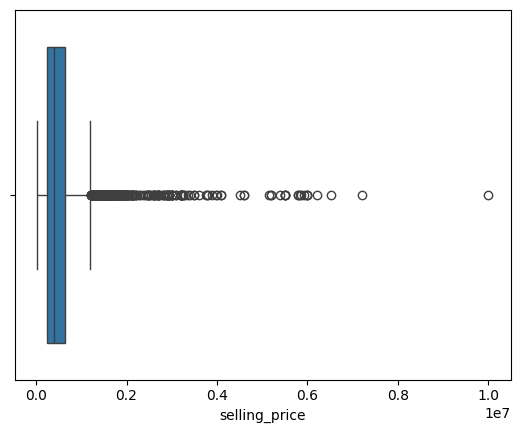

In [25]:
import seaborn as sns
sns.boxplot(x=CarData_Post_Prepro['selling_price'])


In [27]:
# Select only numerical columns for calculating the IQR
numerical_cols = CarData_Post_Prepro.select_dtypes(include=['float64', 'int64'])

# Calculate Q1 (25th percentile) and Q3 (75th percentile) for numerical columns
Q1 = numerical_cols.quantile(0.25)
Q3 = numerical_cols.quantile(0.75)

# Calculate the Interquartile Range (IQR)
IQR = Q3 - Q1

# Filter out rows with outliers (those below Q1 - 1.5*IQR or above Q3 + 1.5*IQR)
CarData_Post_Prepro = CarData_Post_Prepro[~((numerical_cols < (Q1 - 1.5 * IQR)) | (numerical_cols > (Q3 + 1.5 * IQR))).any(axis=1)]

print(f'Number of rows after outlier removal: {CarData_Post_Prepro.shape[0]}')


Number of rows after outlier removal: 4185
